In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Utils

In [37]:
# Data Generation
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0]-pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(inputs), np.array(labels).reshape(n, 1)

def generate_XOR_easy():
    inputs = []
    labels = []
    for i in range(11):
        inputs.append([0.1*i, 0.1*i])
        labels.append(0)
        if 0.1*i == 0.5:
            continue
        inputs.append([0.1*i, 1-0.1*i])
        labels.append(1)
    return np.array(inputs), np.array(labels).reshape(21, 1)

# Visualization
def show_result(x, y, pred_y):
    plt.subplot(1, 2, 1)
    plt.title('Ground truth', fontsize=18)
    for i in range(x.shape[0]):
        if y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.subplot(1, 2, 2)
    plt.title('Predict result', fontsize=18)
    for i in range(x.shape[0]):
        if pred_y[i] == 0:
            plt.plot(x[i][0], x[i][1], 'ro')
        else:
            plt.plot(x[i][0], x[i][1], 'bo')
    plt.show()

def plot_loss(losses):
    plt.plot(losses)
    plt.title('Loss')
    plt.show()

# Training and Testing
def Traning_and_Test(model, data_gen, epoch=100000, **kwargs):
    X, Y = data_gen()
    nn = model(X, Y, **kwargs)
    losses = []
    for i in range(epoch):
        loss = nn.train()
        losses.append(loss)
        if i%5000 == 0:
            print(f"epoch {i}, loss: {loss}")
    plot_loss(losses)
    
    X, Y = data_gen()
    pred_Y = nn.forward(X)
    print(pred_Y)
    pred_label = np.where(pred_Y > 0.5, 1, 0)
    print(f"Accuracy: {np.mean(pred_label == Y)}")
    show_result(X, Y, pred_label)


# Define Neural Network Modules

In [9]:
class module:
    def __init__(self) -> None:
        pass

    def forward(self, *input):
        raise NotImplementedError
    
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    
class ReLU(module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, gradwrtoutput):
        return (self.input > 0) * gradwrtoutput
    
class Sigmoid(module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input):
        self.input = input
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput * (1 - self.forward(self.input)) * self.forward(self.input)
    
class Linear(module):
    def __init__(self, in_shape, out_shape) -> None:
        super().__init__()
        self.W = np.random.rand(in_shape, out_shape)
    
    def forward(self, input):
        self.input = input
        return np.dot(input, self.W)
    
    def backward(self, gradwrtoutput):
        self.gradW = np.dot(self.input.T, gradwrtoutput)
        return np.dot(gradwrtoutput, self.W.T)
    
class Conv1d(module):
    def __init__(self, in_shape, out_shape, kernel_size=2, stride=1) -> None:
        super().__init__()
        self.W = np.random.rand(out_shape, in_shape, kernel_size)
        self.stride = stride
    
    def forward(self, input):
        self.input = input
        if len(input.shape) == 2:
            input = input.reshape(input.shape[0], input.shape[1], 1)
        batch_size, in_shape, in_length = input.shape
        out_length = (in_length - self.W.shape[2]) // self.stride + 1
        self.out_shape = (batch_size, self.W.shape[0], out_length)
        output = np.zeros(self.out_shape)
        for i in range(out_length):
            output[:, :, i] = np.sum(input[:, :, i:i+self.W.shape[2]] * self.W, axis=(1, 2))
        return output
    
    def backward(self, gradwrtoutput):
        gradW = np.zeros(self.W.shape)
        gradinput = np.zeros(self.input.shape)
        for i in range(gradwrtoutput.shape[2]):
            gradW += np.sum(self.input[:, :, i:i+self.W.shape[2]] * gradwrtoutput[:, :, i:i+1], axis=0)
            gradinput[:, :, i:i+self.W.shape[2]] += np.sum(self.W * gradwrtoutput[:, :, i:i+1], axis=1)
        self.gradW = gradW
        return gradinput

# Optimizer Modules

In [13]:
class optimizer:
    def __init__(self, parameters, lr) -> None:
        self.parameters = parameters
        self.lr = lr
    
    def step(self):
        pass

class SGD(optimizer):
    def __init__(self, parameters, lr) -> None:
        super().__init__(parameters, lr)
    
    def step(self):
        for parameter in self.parameters:
            parameter.W -= self.lr * parameter.gradW

class Adagrad(optimizer):
    def __init__(self, parameters, lr) -> None:
        super().__init__(parameters, lr)
        self.eps = 1e-8
        self.G = [np.zeros_like(parameter.W) for parameter in parameters]
    
    def step(self):
        for i, parameter in enumerate(self.parameters):
            self.G[i] += parameter.gradW ** 2
            parameter.W -= self.lr * parameter.gradW / (np.sqrt(self.G[i]) + self.eps)

class Momentum(optimizer):
    def __init__(self, parameters, lr, momentum=0.9) -> None:
        super().__init__(parameters, lr)
        self.momentum = momentum
        self.v = [np.zeros_like(parameter.W) for parameter in parameters]
    
    def step(self):
        for i, parameter in enumerate(self.parameters):
            self.v[i] = self.momentum * self.v[i] + self.lr * parameter.gradW
            parameter.W -= self.v[i]

# Experiment1
- 3 linear layers 
- 4 hidden units 
- learning rate: 0.1
- activation function: Sigmoid
- optimizer: SGD

In [40]:
class NN1:
    def __init__(self, X, Y, n_hidden=4, lr=0.1):
        self.X = X
        self.Y = Y
        self.n_hidden = n_hidden
        self.weights1 = Linear(self.X.shape[1], self.n_hidden)
        self.weights2 = Linear(self.n_hidden, self.n_hidden)
        self.weights3 = Linear(self.n_hidden, 1)
        self.sigmoid1 = Sigmoid()
        self.sigmoid2 = Sigmoid()
        self.sigmoid3 = Sigmoid()
        self.lr = lr
        self.optimizer = SGD([self.weights1, self.weights2, self.weights3], self.lr)

    def forward(self, input):
        self.a1 = self.weights1.forward(input)
        self.b1 = self.sigmoid1.forward(self.a1)
        self.a2 = self.weights2.forward(self.b1)
        self.b2 = self.sigmoid2.forward(self.a2)
        self.a3 = self.weights3.forward(self.b2)
        self.out = self.sigmoid3.forward(self.a3)
        return self.out
    
    def train(self):
        y = self.forward(self.X)
        loss = np.sum((y-self.Y)**2)
        
        # Backpropagation
        dloss_dy = 2*(y-self.Y)
        dou_da3 = self.sigmoid3.backward(dloss_dy)
        da3_db2 = self.weights3.backward(dou_da3)
        db2_da2 = self.sigmoid2.backward(da3_db2)
        da2_db1 = self.weights2.backward(db2_da2)
        db1_da1 = self.sigmoid1.backward(da2_db1)
        da1_dw1 = self.weights1.backward(db1_da1)
        
        # Update Weights
        self.optimizer.step()

        return loss

epoch 0, loss: 37.94746264041069
epoch 5000, loss: 0.00418731620554357
epoch 10000, loss: 0.0017156320142404668
epoch 15000, loss: 0.0010389577837274615
epoch 20000, loss: 0.0007330081782245369
epoch 25000, loss: 0.0005611696358222543
epoch 30000, loss: 0.0004520249452818533
epoch 35000, loss: 0.00037695903905070804
epoch 40000, loss: 0.0003223689537266793
epoch 45000, loss: 0.00028099480958112714
epoch 50000, loss: 0.00024862262404790807
epoch 55000, loss: 0.0002226450436129874
epoch 60000, loss: 0.00020136555542941173
epoch 65000, loss: 0.00018363445794410512
epoch 70000, loss: 0.00016864598730115246
epoch 75000, loss: 0.00015581925475326928
epoch 80000, loss: 0.00014472528820202998
epoch 85000, loss: 0.00013504065784864164
epoch 90000, loss: 0.0001265170572571493
epoch 95000, loss: 0.00011896079727669791


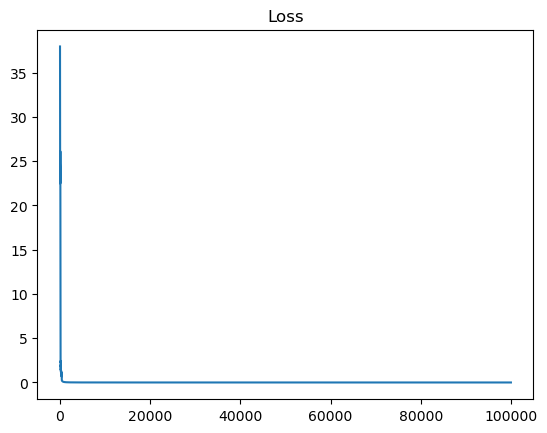

[[9.99996053e-01]
 [1.34790155e-06]
 [1.46840629e-06]
 [8.82530228e-05]
 [9.99997515e-01]
 [9.99997793e-01]
 [3.80826701e-03]
 [9.99997568e-01]
 [1.35982267e-06]
 [9.99996887e-01]
 [9.99997760e-01]
 [1.38015702e-06]
 [9.99997729e-01]
 [9.99997762e-01]
 [9.99997750e-01]
 [1.34363057e-06]
 [9.99997259e-01]
 [3.23781865e-04]
 [6.76085089e-05]
 [1.37978576e-06]
 [9.99763910e-01]
 [1.37718402e-06]
 [1.32613375e-06]
 [1.36206368e-06]
 [1.52535646e-06]
 [9.99997663e-01]
 [1.34609525e-06]
 [1.34490839e-06]
 [1.93180886e-06]
 [9.99991748e-01]
 [9.99476093e-01]
 [9.99076028e-01]
 [9.99997550e-01]
 [9.99997794e-01]
 [1.62883142e-06]
 [9.99997662e-01]
 [9.99997511e-01]
 [9.99997800e-01]
 [9.99988996e-01]
 [9.52550505e-06]
 [2.53269305e-06]
 [1.40797597e-06]
 [1.65499334e-06]
 [3.33669635e-03]
 [9.99997779e-01]
 [1.34214180e-06]
 [9.99996291e-01]
 [9.99997648e-01]
 [1.65785155e-06]
 [9.99914505e-01]
 [2.21284923e-06]
 [9.99996985e-01]
 [6.96829716e-06]
 [9.99997792e-01]
 [1.38774194e-06]
 [5.117855

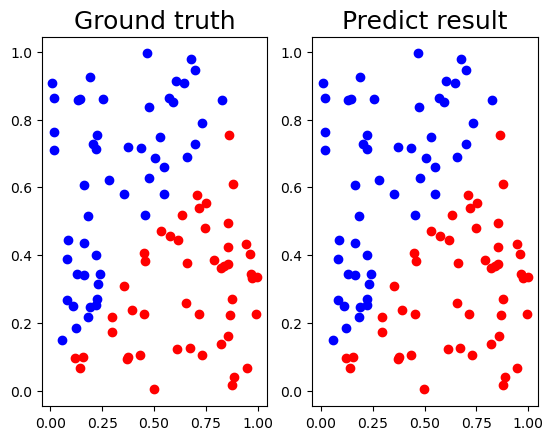

In [41]:
Traning_and_Test(NN1, generate_linear)

epoch 0, loss: 7.64490361104635
epoch 5000, loss: 0.007420738765364139
epoch 10000, loss: 0.0020293006499668732
epoch 15000, loss: 0.0011024651381666343
epoch 20000, loss: 0.0007396241974867567
epoch 25000, loss: 0.0005500388629585189
epoch 30000, loss: 0.00043478256530007724
epoch 35000, loss: 0.0003578164041992481
epoch 40000, loss: 0.0003030203876212187
epoch 45000, loss: 0.0002621507642847601
epoch 50000, loss: 0.00023057186098197031
epoch 55000, loss: 0.00020548500537082953
epoch 60000, loss: 0.00018510457331992065
epoch 65000, loss: 0.00016823973361940168
epoch 70000, loss: 0.000154066985923256
epoch 75000, loss: 0.00014199934230895036
epoch 80000, loss: 0.00013160752003373317
epoch 85000, loss: 0.00012257057392691753
epoch 90000, loss: 0.00011464391949096467
epoch 95000, loss: 0.00010763801262873165


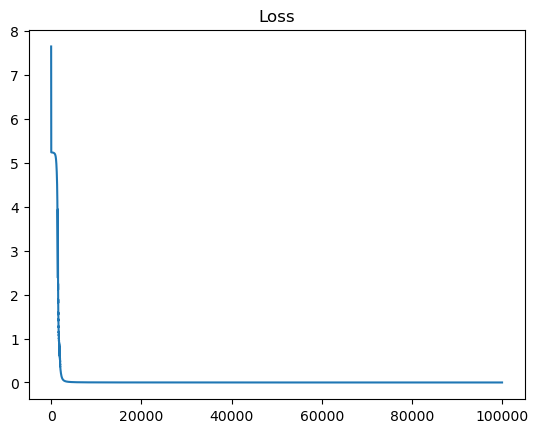

[[4.90465855e-04]
 [9.99988816e-01]
 [1.33817872e-03]
 [9.99988503e-01]
 [2.88872015e-03]
 [9.99987444e-01]
 [4.08404207e-03]
 [9.99977511e-01]
 [3.66380221e-03]
 [9.94791716e-01]
 [2.30139601e-03]
 [1.18060734e-03]
 [9.94836142e-01]
 [5.70516044e-04]
 [9.99977039e-01]
 [2.86279186e-04]
 [9.99986256e-01]
 [1.56736217e-04]
 [9.99986808e-01]
 [9.50380355e-05]
 [9.99986623e-01]]
Accuracy: 1.0


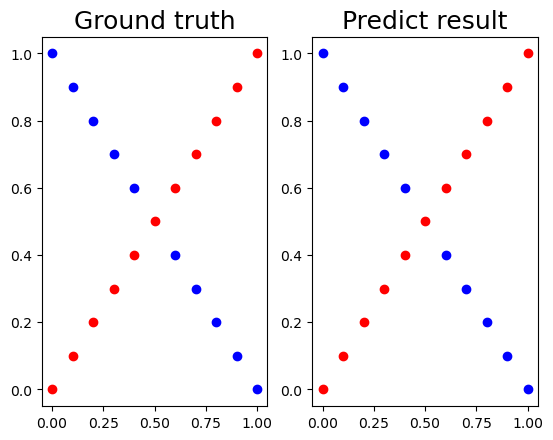

In [42]:
Traning_and_Test(NN1, generate_XOR_easy)